In [1]:
%pylab inline

import json
import numpy as np
from PIL import Image

import torch
import torchvision.models as models
import torchvision.transforms as transforms
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Populating the interactive namespace from numpy and matplotlib


In [2]:
model = models.resnet18(pretrained=True)
model.eval()
class_idx = json.load(open("network_vis/imagenet_class_index.json"))

In [3]:

transform = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])


/Users/arkyyang/opt/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Ranking: class (score)
0: Labrador_retriever (14.7287)
1: Rhodesian_ridgeback (12.4868)
2: vizsla (11.5684)
3: golden_retriever (11.5347)
4: redbone (11.4169)
5: bloodhound (10.6947)
6: English_foxhound (9.7093)
7: Chesapeake_Bay_retriever (9.6129)
8: bull_mastiff (9.1522)
9: Great_Dane (7.9116)


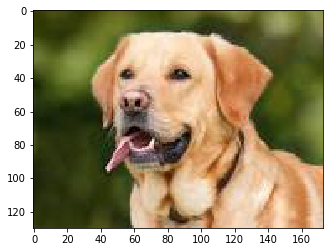

In [4]:
image = transform(Image.open('network_vis/dog.jpg'))
plt.imshow(plt.imread('network_vis/dog.jpg'))

predictions = model(image.unsqueeze(0)).detach().numpy()[0]

print('Ranking: class (score)')
for i, idx in enumerate(np.argsort(predictions)[-10:][::-1]):
    print('%d: %s (%.04f)' % (
            i,
            class_idx[str(idx)][1], 
            predictions[idx]))

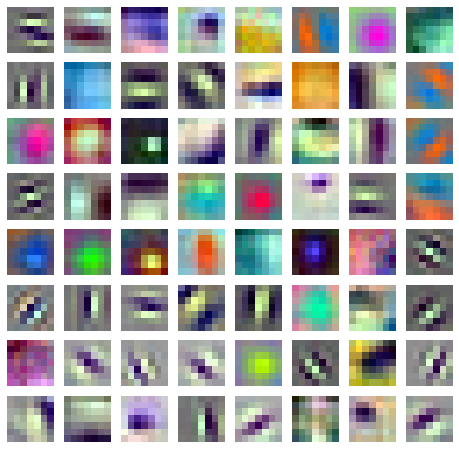

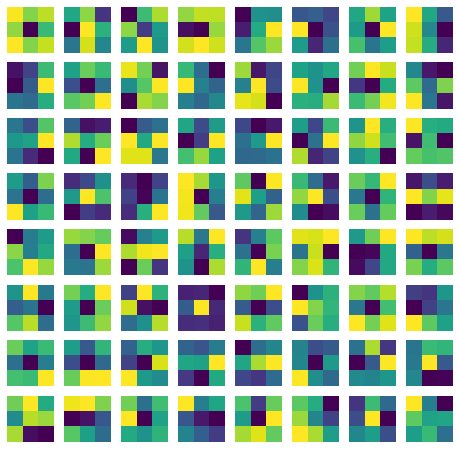

In [5]:
def visualize_layer(weight):
    fig=plt.figure(figsize=(8, 8))

    for i in range(64):
        x = weight[i, ...].transpose([1, 2, 0])
        x = (x - np.min(x))/np.ptp(x)

        fig.add_subplot(8, 8, i + 1)
        if x.shape[2] == 3:
            imshow(x)
        else:
            imshow(x[:,:,0])
        axis('off')

    show()

visualize_layer(model.conv1.weight.data.cpu().numpy())
visualize_layer(model.layer1[0].conv1.weight.data.cpu().numpy())

In [6]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data import load
valid_data = load.get_dogs_and_cats('valid', resize=None, batch_size=128, is_resnet=True)

In [7]:
def undo_transform(x):
    mean = np.array([0.485, 0.456, 0.406])[np.newaxis, :, np.newaxis, np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[np.newaxis, :, np.newaxis, np.newaxis]
    return (x * std) + mean


In [8]:
all_data = []
C1 = []
C2 = []
C3 = []

def store_activation(L, m, grad_in, grad_out):
    L.append(grad_out.detach().cpu().numpy())

model.to(device)

try:
    h1 = model.conv1.register_forward_hook(lambda *args: store_activation(C1, *args))
    h2 = model.layer1[0].conv1.register_forward_hook(lambda *args: store_activation(C2, *args))
    h3 = model.layer2[0].conv1.register_forward_hook(lambda *args: store_activation(C3, *args))
    
    for it, (data, label) in enumerate(valid_data):
        all_data.append(undo_transform(data.numpy()))
        if device is not None:
            data, label = data.to(device), label.to(device)
        result = model(data)
finally:
    h1.remove()
    h2.remove()
    h3.remove()

all_data = np.vstack(all_data)
C1 = np.vstack(C1)
C2 = np.vstack(C2)
C3 = np.vstack(C3)

KeyboardInterrupt: 

In [ ]:
def to_pil(x):
    x = x.transpose((1, 2, 0))
    x -= x.min(0).min(0)[None,None]
    x /= x.max(0).max(0)[None,None]
    return Image.fromarray((x * 255).astype('uint8'))

def viz_act(img, act):
    
    num_acts = len(act)
    img = to_pil(img)

    fig=plt.figure(figsize=(20, 20))

    fig.add_subplot(1, 1+num_acts, 1)
    imshow(img)
    axis('off')

    for i, c in enumerate(act):
        fig.add_subplot(1, 1+num_acts, i + 2)
        imshow(c)
        axis('off')

    show()

for i in range(3):
    viz_act(all_data[i], C1[i, :3])
    
    
for i in range(3):
    viz_act(all_data[i], C2[i, :3])
    
for i in range(3):
    viz_act(all_data[i], C3[i, :3])

In [ ]:
def find_max_act(C, filter, W=10, img_size=[224, 224]):
    fig=plt.figure(figsize=(8, 8))

    filter_act = C[:, filter]
    for i, idx in enumerate(np.argsort(-filter_act, axis=None)[:64]):
        max_pos = list(np.unravel_index(idx, filter_act.shape))

        max_pos[1] = int(max_pos[1] * float(img_size[0]) / filter_act.shape[1])
        max_pos[2] = int(max_pos[2] * float(img_size[1]) / filter_act.shape[2])

        img = to_pil(all_data[max_pos[0], 
                              :,
                              max(max_pos[1] - W, 0) : max_pos[1] + W,
                              max(max_pos[2] - W, 0) : max_pos[2] + W])

        fig.add_subplot(8, 8, i + 1)
        imshow(img)
        axis('off')

    show()

find_max_act(C1, filter=0, W=4)#, img_size=img.size)
find_max_act(C1, filter=1, W=4)#, img_size=img.size)
find_max_act(C1, filter=2, W=4)#, img_size=img.size)

In [ ]:
find_max_act(C2, filter=0, W=12)#, img_size=img.size)
find_max_act(C2, filter=1, W=12)#, img_size=img.size)
find_max_act(C2, filter=2, W=12)#, img_size=img.size)

In [ ]:
find_max_act(C3, filter=0, W=12)#, img_size=img.size)
find_max_act(C3, filter=1, W=12)#, img_size=img.size)
find_max_act(C3, filter=2, W=12)#, img_size=img.size)